In [1]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# transform input into 16 x 16 x 128-channel feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

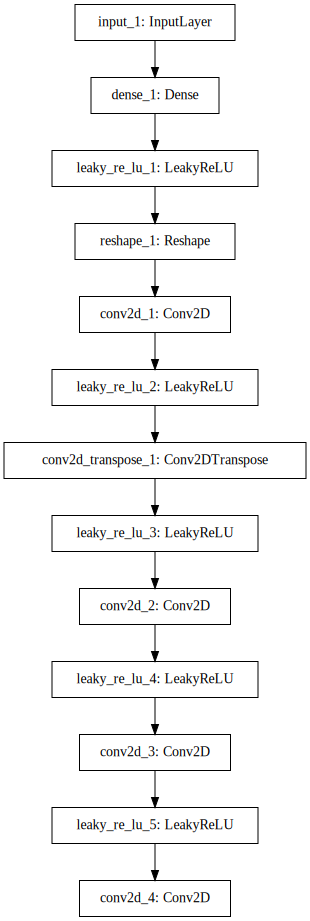

In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(generator).create(prog='dot', format='svg'))

### Discriminator

In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

# classification layer
x = layers.Dense(1, activation='sigmoid')(x)

# turns (32, 32, 3) input to binary classification (fake/real)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

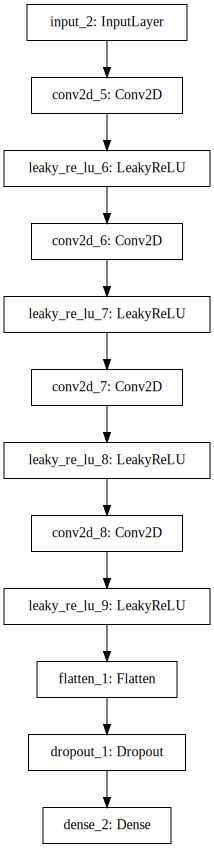

In [4]:
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

In [5]:
# stabilize with learning rate decay
discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer,
                     loss='binary_crossentropy')

In [6]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [9]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_2 (Model)              (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


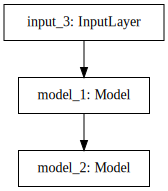

In [10]:
SVG(model_to_dot(gan).create(prog='dot', format='svg'))

### Implement GAN Training

In [7]:
import os
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# select frogs (class 6)
x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
    (x_train.shape[0],) + 
    (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'img'

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
    
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
    # random noise to labels, an important trick
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # sample random points in latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # assemble labels that say 'these images are real' (a lie)
    misleading_targets = np.zeros((batch_size, 1))
    
    # train generator, discriminator weights are frozen
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))
        
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        # save generated image
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        
        # save real image for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))
        

/home/dhodun/.local/lib/python2.7/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


('discriminator loss:', 0.70029199)
('adversarial loss:', 0.70033932)
('discriminator loss:', 0.69081324)
('adversarial loss:', 0.76027352)
('discriminator loss:', 0.70888245)
('adversarial loss:', 1.0338711)
('discriminator loss:', 0.7045148)
('adversarial loss:', 0.7311765)
('discriminator loss:', 0.70367324)
('adversarial loss:', 0.73808706)
('discriminator loss:', 0.68389189)
('adversarial loss:', 0.75992399)
('discriminator loss:', 0.6866864)
('adversarial loss:', 0.73675853)
('discriminator loss:', 0.69571608)
('adversarial loss:', 0.76351631)
('discriminator loss:', 0.69543999)
('adversarial loss:', 0.75592953)
('discriminator loss:', 0.70261973)
('adversarial loss:', 0.74636847)
('discriminator loss:', 0.77731258)
('adversarial loss:', 0.79022634)
('discriminator loss:', 0.69657481)
('adversarial loss:', 0.73791134)
('discriminator loss:', 0.69945419)
('adversarial loss:', 0.7739324)
('discriminator loss:', 0.69325668)
('adversarial loss:', 0.76899588)
('discriminator loss:', 0

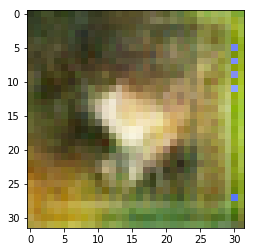

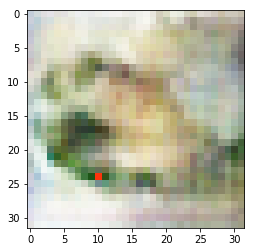

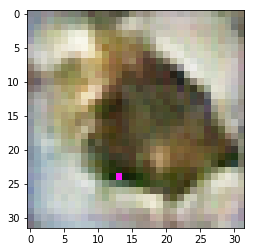

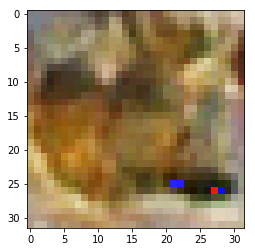

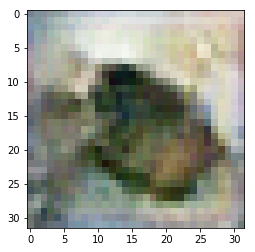

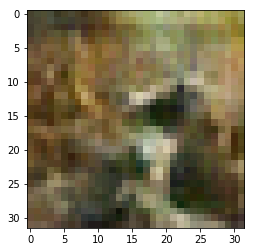

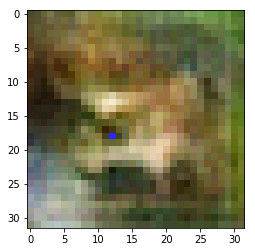

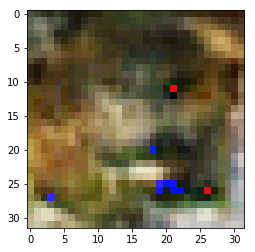

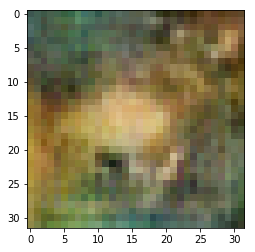

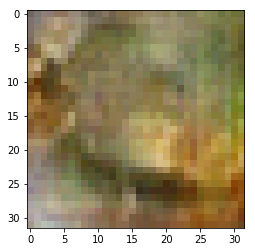

In [8]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()